📹 Orijinal boyut: 1920x1080


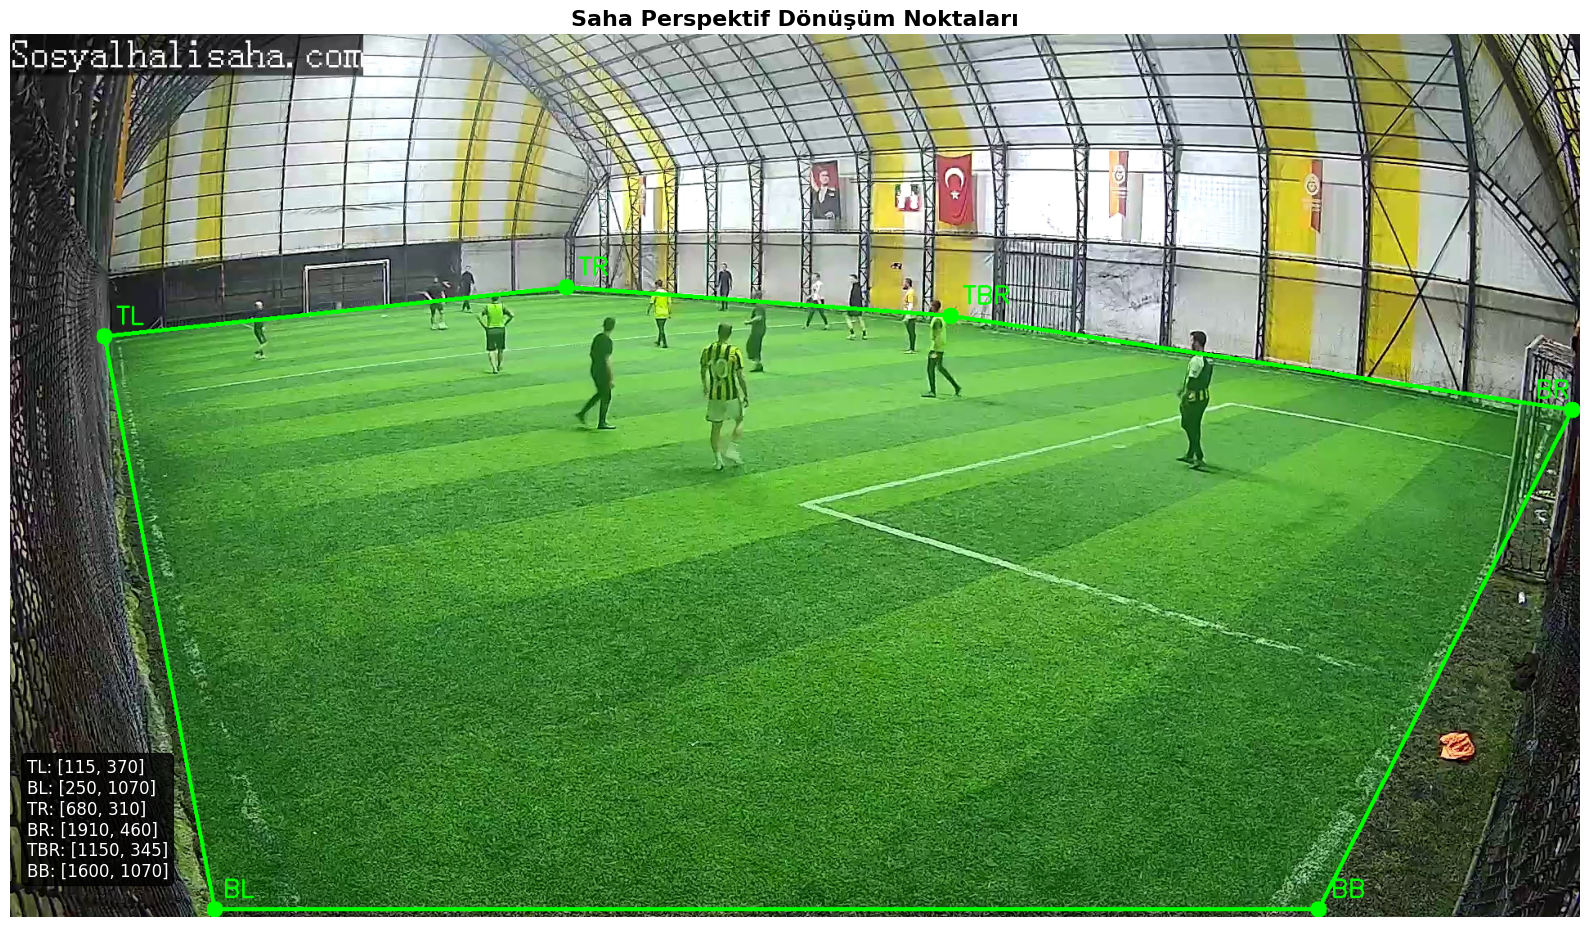


✅ İşlem tamamlandı!


In [2]:
# ---------------------------
# Tek Frame Üzerinde Saha Koordinatları Belirleme
# ---------------------------
import cv2
import numpy as np
import matplotlib.pyplot as plt

VIDEO_PATH = 'shs2.mp4'
vidcap = cv2.VideoCapture(VIDEO_PATH)

if not vidcap.isOpened():
    print("❌ Hata: Video dosyası açılamadı! '{VIDEO_PATH}' dosyasının mevcut olduğundan emin olun.")
else:
    success, image = vidcap.read()
    
    if success and image is not None:
        height, width = image.shape[:2]
        print("📹 Orijinal boyut: {width}x{height}")
        frame = image.copy()  # Orijinal boyutta kullan
        tl = [115,370]   # top-left
        bl = [250, 1070]   # bottom-left
        tr = [680, 310]  # top-right
        br = [1910, 460]  # bottom-right
        bb = [1600, 1070]   # bottom-bot
        tbr = [1150, 345]   # right-connector
        
        # Koordinat noktalarını işaretle (yeşil daireler)
        cv2.circle(frame, tl, 10, (0, 255, 0), -1)
        cv2.circle(frame, bl, 10, (0, 255, 0), -1)
        cv2.circle(frame, tr, 10, (0, 255, 0), -1)
        cv2.circle(frame, br, 10, (0, 255, 0), -1)
        cv2.circle(frame, bb, 10, (0, 255, 0), -1)
        cv2.circle(frame, tbr, 10, (0, 255, 0), -1)
        
        # Nokta isimlerini ekle
        cv2.putText(frame, 'TL', (tl[0]+15, tl[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        cv2.putText(frame, 'BL', (bl[0]+10, bl[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        cv2.putText(frame, 'TR', (tr[0]+15, tr[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        cv2.putText(frame, 'BR', (br[0]-45, br[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        cv2.putText(frame, 'BB', (bb[0]+15, bb[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        cv2.putText(frame, 'TBR', (tbr[0]+15, tbr[1]-15), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

        
        # Noktaları tek bir çokgen olarak birleştir
        points = np.array([tl, tr, tbr, br, bb, bl], np.int32)  # Saat yönünde sıralama
        points = points.reshape((-1, 1, 2))

        # Çokgenin kenarlarını çiz (yeşil çizgiler)
        cv2.polylines(frame, [points], isClosed=True, color=(0, 255, 0), thickness=3)

        # Çokgenin içini doldur (yarı saydam yeşil)
        overlay = frame.copy()
        cv2.fillPoly(overlay, [points], color=(0, 255, 0))
        alpha = 0.2  # saydamlık seviyesi
        frame = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)
        
        # BGR'den RGB'ye çevir (matplotlib için)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Matplotlib ile göster
        plt.figure(figsize=(16, 10))
        plt.imshow(frame_rgb)
        plt.title('Saha Perspektif Dönüşüm Noktaları', fontsize=16, fontweight='bold')
        plt.axis('off')
        
        # Koordinatları göster (sol alt köşede)
        coord_text = "TL: {tl}\nBL: {bl}\nTR: {tr}\nBR: {br}\nTBR: {tbr}\nBB: {bb}"
        plt.text(20, height-50, coord_text, fontsize=12, color='white', 
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
    else:
        print("❌ Frame okunamadı!")
    
    # Kaynakları temizle
    vidcap.release()

print("\n✅ İşlem tamamlandı!")

In [1]:
# MULTI-PLAYER TRACKING - FIXED 14 PLAYERS (ANTI-SWAP V5)
# Sabit oyuncu sayısı, ID asla değişmez, oyuncu asla silinmez
import cv2
import numpy as np
from ultralytics import YOLO
from collections import defaultdict, deque
import time
import torch
from scipy.optimize import linear_sum_assignment

# ---------- CONFIG ----------
VIDEO_PATH = "shs2.mp4"
OUTPUT_PATH = "shs2_fixed_players_v5.mp4"
YOLO_MODEL = "yolov8m.pt"

# SABİT OYUNCU SAYISI (hedef)
FIXED_PLAYER_COUNT = 14

# Geometrik eşleştirme parametreleri
MAX_REID_DIST = 35**2
MAX_REID_DIST_PREDICTED = 60**2  # Tahmin modundaki oyuncular için
MAX_PREDICTION_FRAMES = 60       # Max kaç frame tahminle gidebilir

# Histogram parametreleri
HIST_SIZE = (32, 32)
HIST_RANGE = [0, 180, 0, 256]
SHIRT_WEIGHT = 18.0
PANTS_WEIGHT = 12.0
HIST_ALPHA = 0.95

# Anti-swap parametreleri
VELOCITY_WEIGHT = 8.0
MIN_IOU_FOR_MATCH = 0.15
MAX_VELOCITY_CHANGE = 45
DISTANCE_PENALTY = 0.10
DIRECTION_WEIGHT = 6.0
SIZE_WEIGHT = 10.0
MAX_SIZE_CHANGE = 0.40

# Spatial kontrol
MAX_X_JUMP = 120
MAX_Y_JUMP = 80
SPATIAL_PENALTY = 12.0

POSITION_HISTORY_LEN = 10
LOCK_THRESHOLD = 6

# --------- BIRD VIEW CONFIG ----------
tl  = [115, 370]
bl  = [250, 1070]
tr  = [680, 310]
br  = [1910, 460]
bb  = [1600, 1070]
tbr = [1150, 345]

SRC_POINTS = np.float32([tl, bl, tr, br, bb, tbr])
DST_POINTS = np.float32([
    [50,  50],
    [50,  550],
    [350, 50],
    [350, 550],
    [200, 550],
    [350, 300],
])

BIRD_WIDTH = 500
BIRD_HEIGHT = 600

FIELD_WIDTH_M = 15.0
FIELD_HEIGHT_M = 30.0
PIXELS_PER_METER_X = 300.0 / FIELD_WIDTH_M
PIXELS_PER_METER_Y = 500.0 / FIELD_HEIGHT_M

device = "cuda" if torch.cuda.is_available() else "cpu"
yolo = YOLO(YOLO_MODEL)
yolo.to(device)
imgsz = 1280
MAX_INIT_FRAMES = 60  # İlk frame için daha fazla deneme

# ------------ HELPER FONKSİYONLAR ------------
def bbox_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    areaA = max(0, (boxA[2] - boxA[0])) * max(0, (boxA[3] - boxA[1]))
    areaB = max(0, (boxB[2] - boxB[0])) * max(0, (boxB[3] - boxB[1]))

    union = areaA + areaB - interArea
    if union <= 0:
        return 0.0
    return interArea / union


def bbox_area(bbox):
    return max(0, bbox[2] - bbox[0]) * max(0, bbox[3] - bbox[1])


def clamp_bbox_to_frame(bbox, w_img, h_img):
    """BBox'ı frame sınırlarına clamp eder."""
    x1, y1, x2, y2 = bbox
    x1 = max(0, min(x1, w_img - 1))
    x2 = max(0, min(x2, w_img - 1))
    y1 = max(0, min(y1, h_img - 1))
    y2 = max(0, min(y2, h_img - 1))
    if x2 <= x1:
        x2 = min(w_img - 1, x1 + 1)
    if y2 <= y1:
        y2 = min(h_img - 1, y1 + 1)
    return (x1, y1, x2, y2)


def get_color_category(frame, bbox):
    """Oyuncunun renk kategorisini belirler."""
    x1, y1, x2, y2 = bbox
    h_img, w_img = frame.shape[:2]
    
    x1 = max(0, min(x1, w_img - 1))
    x2 = max(0, min(x2, w_img))
    y1 = max(0, min(y1, h_img - 1))
    y2 = max(0, min(y2, h_img))
    
    if x2 <= x1 or y2 <= y1:
        return 'other', None
    
    h = y2 - y1
    w = x2 - x1
    
    shirt_y1 = y1 + int(h * 0.15)
    shirt_y2 = y1 + int(h * 0.50)
    margin = int(w * 0.15)
    shirt_x1 = x1 + margin
    shirt_x2 = x2 - margin
    
    if shirt_x2 <= shirt_x1 or shirt_y2 <= shirt_y1:
        return 'other', None
    
    crop = frame[shirt_y1:shirt_y2, shirt_x1:shirt_x2]
    if crop.size == 0:
        return 'other', None
    
    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)
    
    mask = np.ones(hsv.shape[:2], dtype=np.uint8) * 255
    grass_mask = ((H >= 25) & (H <= 100) & (S >= 35))
    mask[grass_mask] = 0
    
    valid_pixels = cv2.countNonZero(mask)
    if valid_pixels < 30:
        return 'other', None
    
    masked_H = H[mask > 0]
    masked_S = S[mask > 0]
    masked_V = V[mask > 0]
    
    avg_h = float(np.mean(masked_H))
    avg_s = float(np.mean(masked_S))
    avg_v = float(np.mean(masked_V))
    
    h_std = float(np.std(masked_H))
    v_std = float(np.std(masked_V))
    
    yellow_count = np.sum((masked_H >= 15) & (masked_H <= 35) & (masked_S >= 80))
    black_count = np.sum((masked_V < 60))
    total = len(masked_H)
    
    if total > 0:
        yellow_ratio = yellow_count / total
        black_ratio = black_count / total
        
        if yellow_ratio > 0.2 and black_ratio > 0.15 and (h_std > 20 or v_std > 40):
            return 'yellow_stripe', (avg_h, avg_s, avg_v)
        
        if avg_v < 70 and avg_s < 80:
            return 'black', (avg_h, avg_s, avg_v)
        
        if 15 <= avg_h <= 40 and avg_s >= 80 and avg_v >= 150:
            return 'yellow', (avg_h, avg_s, avg_v)

        if 35 <= avg_h <= 80 and avg_s >= 100 and avg_v >= 150:
            return 'green_vest', (avg_h, avg_s, avg_v)
        
        if avg_s < 40 and avg_v > 180:
            return 'white', (avg_h, avg_s, avg_v)
    
    return 'other', (avg_h, avg_s, avg_v)


def color_category_match(cat1, cat2):
    """İki renk kategorisinin uyumluluğunu kontrol eder."""
    if cat1 == cat2:
        return 0.0
    
    similar_pairs = [
        ('yellow', 'yellow_stripe'),
        ('yellow', 'green_vest'),
    ]
    
    for pair in similar_pairs:
        if (cat1 in pair and cat2 in pair):
            return 5.0
    
    return 20.0


def get_clean_hist(frame, bbox):
    x1, y1, x2, y2 = bbox
    h_img, w_img = frame.shape[:2]

    x1 = max(0, min(x1, w_img - 1))
    x2 = max(0, min(x2, w_img))
    y1 = max(0, min(y1, h_img - 1))
    y2 = max(0, min(y2, h_img))

    if x2 <= x1 or y2 <= y1:
        return None

    crop = frame[y1:y2, x1:x2]

    if crop.size == 0 or crop.shape[0] < 20 or crop.shape[1] < 10:
        return None

    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)

    mask = np.ones(hsv.shape[:2], dtype=np.uint8) * 255
    grass_mask = ((H >= 25) & (H <= 100) & (S >= 35))
    mask[grass_mask] = 0
    dark_mask = (V < 20)
    bright_mask = (V > 250) & (S < 20)
    mask[dark_mask] = 0
    mask[bright_mask] = 0

    if cv2.countNonZero(mask) < 50:
        return None

    hist = cv2.calcHist([hsv], [0, 1], mask, HIST_SIZE, HIST_RANGE)
    cv2.normalize(hist, hist)
    return hist


def compute_shirt_pants_bboxes(bbox):
    x1, y1, x2, y2 = bbox
    w = x2 - x1
    h = y2 - y1
    if h <= 0 or w <= 0:
        return None, None

    margin_w = int(w * 0.25)
    inner_x1 = x1 + margin_w
    inner_x2 = x2 - margin_w
    if inner_x2 <= inner_x1:
        inner_x1, inner_x2 = x1, x2

    shirt_top    = y1 + int(h * 0.18)
    shirt_bottom = y1 + int(h * 0.48)
    pants_top    = y1 + int(h * 0.48)
    pants_bottom = y1 + int(h * 0.78)

    shirt_bbox = (inner_x1, max(y1, shirt_top), inner_x2, min(y2, shirt_bottom))
    pants_bbox = (inner_x1, max(y1, pants_top), inner_x2, min(y2, pants_bottom))

    return shirt_bbox, pants_bbox


def get_shirt_pants_hist(frame, bbox):
    shirt_bbox, pants_bbox = compute_shirt_pants_bboxes(bbox)
    
    shirt_hist = None
    pants_hist = None
    
    if shirt_bbox is not None:
        shirt_hist = get_clean_hist(frame, shirt_bbox)
    
    if pants_bbox is not None:
        pants_hist = get_clean_hist(frame, pants_bbox)
    
    return shirt_hist, pants_hist


def smooth_histogram(old_hist, new_hist, alpha=HIST_ALPHA):
    if old_hist is None:
        return new_hist
    if new_hist is None:
        return old_hist
    
    smoothed = alpha * old_hist + (1 - alpha) * new_hist
    cv2.normalize(smoothed, smoothed)
    return smoothed


def init_kalman(x, y):
    kf = cv2.KalmanFilter(4, 2)
    
    kf.transitionMatrix = np.array([[1, 0, 1, 0],
                                    [0, 1, 0, 1],
                                    [0, 0, 1, 0],
                                    [0, 0, 0, 1]], np.float32)
    
    kf.measurementMatrix = np.array([[1, 0, 0, 0],
                                     [0, 1, 0, 0]], np.float32)
    
    kf.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03
    kf.measurementNoiseCov = np.eye(2, dtype=np.float32) * 2.0
    kf.statePost = np.array([[x], [y], [0.0], [0.0]], np.float32)
    
    return kf


def compute_velocity_consistency(kalman, new_cx, new_cy):
    state = kalman.statePost
    pred_vx = state[2, 0]
    pred_vy = state[3, 0]
    
    prev_x = state[0, 0]
    prev_y = state[1, 0]
    
    actual_vx = new_cx - prev_x
    actual_vy = new_cy - prev_y
    
    vx_diff = abs(actual_vx - pred_vx)
    vy_diff = abs(actual_vy - pred_vy)
    
    return np.sqrt(vx_diff**2 + vy_diff**2)


def compute_spatial_jump(last_center, new_center):
    dx = abs(new_center[0] - last_center[0])
    dy = abs(new_center[1] - last_center[1])
    return dx, dy


def compute_direction_consistency(position_history, new_cx, new_cy):
    if len(position_history) < 3:
        return 0.0
    
    recent_positions = list(position_history)[-5:]
    
    if len(recent_positions) < 2:
        return 0.0
    
    dx_avg = 0
    dy_avg = 0
    count = 0
    
    for i in range(1, len(recent_positions)):
        dx_avg += recent_positions[i][0] - recent_positions[i-1][0]
        dy_avg += recent_positions[i][1] - recent_positions[i-1][1]
        count += 1
    
    if count == 0:
        return 0.0
    
    dx_avg /= count
    dy_avg /= count
    
    last_pos = recent_positions[-1]
    new_dx = new_cx - last_pos[0]
    new_dy = new_cy - last_pos[1]
    
    mag_avg = np.sqrt(dx_avg**2 + dy_avg**2)
    mag_new = np.sqrt(new_dx**2 + new_dy**2)
    
    if mag_avg < 3 or mag_new < 3:
        return 0.0
    
    dx_avg /= mag_avg
    dy_avg /= mag_avg
    new_dx /= mag_new
    new_dy /= mag_new
    
    dot = dx_avg * new_dx + dy_avg * new_dy
    direction_penalty = max(0, 1 - dot)
    
    return direction_penalty


def compute_appearance_distance(hist1, hist2):
    if hist1 is None or hist2 is None:
        return 0.5
    
    correl = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    bhatta = cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)
    
    distance = (1 - correl) * 0.5 + bhatta * 0.5
    return distance


def compute_size_consistency(last_bbox, new_bbox, avg_size):
    last_area = bbox_area(last_bbox)
    new_area = bbox_area(new_bbox)
    
    if last_area == 0 or new_area == 0:
        return 1.0
    
    ratio1 = min(last_area, new_area) / max(last_area, new_area)
    
    if avg_size > 0:
        ratio2 = min(avg_size, new_area) / max(avg_size, new_area)
    else:
        ratio2 = ratio1
    
    avg_ratio = (ratio1 + ratio2) / 2
    
    if avg_ratio < (1 - MAX_SIZE_CHANGE):
        return (1 - avg_ratio) * 2
    
    return (1 - avg_ratio)


def build_cost_matrix(players, detections):
    """
    Sabit oyuncu ID'leri için maliyet matrisi.
    Her oyuncu mutlaka bir deteksiyona eşleşmeli VEYA tahmin kullanılmalı.
    """
    n_players = len(players)
    n_dets = len(detections)
    
    if n_players == 0:
        return None, [], []
    
    player_list = list(players.items())
    
    # Eğer deteksiyon yoksa, tüm oyuncular tahminle gider
    if n_dets == 0:
        return None, player_list, []
    
    cost_matrix = np.full((n_players, n_dets), 1e6, dtype=np.float32)
    
    for pi, (lid, st) in enumerate(player_list):
        state = st["kalman"].statePost
        pred_x = state[0, 0]
        pred_y = state[1, 0]
        
        last_bbox = st["last_bbox"]
        last_center = st["last_center"]
        player_shirt_hist = st["shirt_hist"]
        player_pants_hist = st["pants_hist"]
        position_history = st["position_history"]
        avg_size = st["avg_bbox_size"]
        player_color_cat = st["color_category"]
        is_locked = st["consecutive_matches"] >= LOCK_THRESHOLD
        prediction_frames = st["prediction_frames"]
        
        # Tahmin modundaysa daha geniş arama
        if prediction_frames > 0:
            max_dist = MAX_REID_DIST_PREDICTED
            max_x = MAX_X_JUMP * (1 + prediction_frames * 0.1)
            max_y = MAX_Y_JUMP * (1 + prediction_frames * 0.1)
        elif is_locked:
            max_dist = MAX_REID_DIST * 0.7
            max_x = MAX_X_JUMP * 0.7
            max_y = MAX_Y_JUMP * 0.7
        else:
            max_dist = MAX_REID_DIST
            max_x = MAX_X_JUMP
            max_y = MAX_Y_JUMP
        
        for di, det in enumerate(detections):
            x1, y1, x2, y2 = det["bbox"]
            cx, cy = det["center"]
            det_color_cat = det["color_category"]
            
            # 1) Spatial jump kontrolü
            dx, dy = compute_spatial_jump(last_center, (cx, cy))
            
            if prediction_frames == 0:  # Aktif takipteyse katı kontrol
                if dx > max_x or dy > max_y:
                    continue
            else:  # Tahmin modundaysa daha esnek
                if dx > max_x * 2 or dy > max_y * 2:
                    continue
            
            # 2) Mesafe kontrolü
            d = (cx - pred_x) ** 2 + (cy - pred_y) ** 2
            if d > max_dist * (1 + prediction_frames * 0.2):
                continue
            
            # 3) Renk kategorisi kontrolü
            color_cat_penalty = color_category_match(player_color_cat, det_color_cat)
            
            if is_locked and prediction_frames == 0 and color_cat_penalty > 10:
                continue
            
            # 4) IoU hesapla
            iou = bbox_iou(last_bbox, (x1, y1, x2, y2))
            # Locked oyuncular için çok düşük IoU kabul etme
            if is_locked and prediction_frames == 0 and iou < MIN_IOU_FOR_MATCH:
                continue
            
            # 5) Velocity consistency
            vel_diff = compute_velocity_consistency(st["kalman"], cx, cy)
            max_vel = MAX_VELOCITY_CHANGE * (1 + prediction_frames * 0.1)
            if vel_diff > max_vel and prediction_frames == 0:
                continue
            
            # 6) Boyut tutarlılığı
            size_diff = compute_size_consistency(last_bbox, (x1, y1, x2, y2), avg_size)
            
            # 7) Direction consistency
            dir_penalty = compute_direction_consistency(position_history, cx, cy)
            
            # 8) Appearance distance
            shirt_dist = compute_appearance_distance(player_shirt_hist, det["shirt_hist"])
            pants_dist = compute_appearance_distance(player_pants_hist, det["pants_hist"])
            
            # 9) Maliyet hesaplama
            cost = 0.0
            
            cost -= iou * 15.0
            cost += np.sqrt(d) * DISTANCE_PENALTY
            
            spatial_penalty = (dx / MAX_X_JUMP + dy / MAX_Y_JUMP) * SPATIAL_PENALTY
            cost += spatial_penalty
            
            cost += color_cat_penalty
            cost += shirt_dist * SHIRT_WEIGHT
            cost += pants_dist * PANTS_WEIGHT
            cost += vel_diff * 0.05 * VELOCITY_WEIGHT
            cost += dir_penalty * DIRECTION_WEIGHT
            cost += size_diff * SIZE_WEIGHT
            cost -= st["stability"] * 0.2
            
            if is_locked:
                cost -= 5.0
            
            # Tahmin modundaki oyuncuya bulunma bonusu
            if prediction_frames > 0:
                cost -= 3.0  # Kayıp oyuncuyu bulmak için bonus
            
            if st["consecutive_matches"] > 3:
                cost -= min(st["consecutive_matches"] * 0.4, 3.0)
            
            cost_matrix[pi, di] = cost
    
    return cost_matrix, player_list, detections


def estimate_bbox_from_center(center, avg_width, avg_height):
    """Merkez noktasından bbox tahmin et"""
    cx, cy = center
    half_w = max(1, avg_width // 2)
    half_h = max(1, avg_height // 2)
    return (cx - half_w, cy - half_h, cx + half_w, cy + half_h)


# ------------ VIDEO İŞLEME ------------
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError("Cannot open video: {VIDEO_PATH}")

# Toplam frame sayısı vb. (video değişmeyeceği için şimdi alabiliriz)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# İlk frame'de tam 14 oyuncu bulana kadar dene
init_frame = None
init_boxes = None
init_frame_idx = None

best_frame = None
best_boxes = None
best_count = 0
best_frame_idx = None

print("Searching for frame with {FIXED_PLAYER_COUNT} players...")

for init_idx in range(MAX_INIT_FRAMES):
    ret, frame = cap.read()
    if not ret:
        break

    results = yolo(
        frame,
        classes=[0],
        conf=0.20,  # Daha düşük confidence
        iou=0.4,
        imgsz=imgsz,
        verbose=False,
        device=device
    )[0]

    if results.boxes is not None and len(results.boxes) > 0:
        boxes = results.boxes.xyxy.cpu().numpy()
        count = len(boxes)
        
        print("  Frame {init_idx}: {count} kişi bulundu")
        
        # En iyi frame'i güncelle
        if count > best_count:
            best_count = count
            best_frame = frame.copy()
            best_boxes = boxes.copy()
            best_frame_idx = init_idx
        
        # Tam 14 bulunduysa hemen kullan
        if count == FIXED_PLAYER_COUNT:
            init_frame = frame.copy()
            init_boxes = boxes
            init_frame_idx = init_idx
            print("✓ Found exactly {FIXED_PLAYER_COUNT} players at frame {init_idx}")
            break

# Tam 14 bulamadıysak en iyi frame'i kullan
if init_frame is None:
    if best_frame is not None and best_count >= FIXED_PLAYER_COUNT - 2:
        # Eğer best_count > FIXED_PLAYER_COUNT ise alanı en büyük olanlardan FIXED_PLAYER_COUNT tanesini al
        areas = [bbox_area(b) for b in best_boxes]
        sorted_indices = np.argsort(areas)[::-1]  # büyükten küçüğe
        selected_count = min(best_count, FIXED_PLAYER_COUNT)
        selected_indices = sorted_indices[:selected_count]
        init_boxes = best_boxes[selected_indices]

        init_frame = best_frame
        init_frame_idx = best_frame_idx

        print("⚠ Using best frame {best_frame_idx} with {best_count} players "
              "(taking {len(init_boxes)})")
    else:
        cap.release()
        raise RuntimeError("Could not find enough players. Best: {best_count}")

print("\n✓ Initializing with {len(init_boxes)} players at frame {init_frame_idx}")

# Oyuncu state'leri oluştur
players = {}

for player_id in range(len(init_boxes)):
    box = init_boxes[player_id]
    x1, y1, x2, y2 = map(int, box)
    center = ((x1 + x2) // 2, (y1 + y2) // 2)
    cx, cy = center
    w = x2 - x1
    h = y2 - y1
    
    kf = init_kalman(cx, cy)
    shirt_hist, pants_hist = get_shirt_pants_hist(init_frame, (x1, y1, x2, y2))
    color_cat, color_vals = get_color_category(init_frame, (x1, y1, x2, y2))
    init_bbox_area = bbox_area((x1, y1, x2, y2))

    players[player_id] = {
        "id": player_id,
        "last_bbox": (x1, y1, x2, y2),
        "last_center": center,
        "avg_width": w,
        "avg_height": h,
        "trajectory": deque(maxlen=300),
        "bird_trajectory": deque(maxlen=300),
        "position_history": deque(maxlen=POSITION_HISTORY_LEN),
        "bbox_size_history": deque(maxlen=20),
        "avg_bbox_size": init_bbox_area,
        "total_distance": 0.0,
        "last_bird_pos": None,
        "color": None,
        "found_frames": 0,
        "shirt_hist": shirt_hist,
        "pants_hist": pants_hist,
        "shirt_hist_original": shirt_hist.copy() if shirt_hist is not None else None,
        "pants_hist_original": pants_hist.copy() if pants_hist is not None else None,
        "color_category": color_cat,
        "color_category_original": color_cat,
        "color_values": color_vals,
        "stability": 5.0,
        "kalman": kf,
        "prediction_frames": 0,  # Kaç frame'dir tahminle gidiyor
        "consecutive_matches": 0,
        "last_seen_frame": init_frame_idx,
    }
    
    players[player_id]["position_history"].append(center)
    players[player_id]["bbox_size_history"].append(init_bbox_area)
    
    print("  Player {player_id}: {color_cat}, pos=({cx}, {cy}), size={w}x{h}")

# Gerçek oyuncu sayısı
ACTUAL_PLAYER_COUNT = len(players)

# Görsel renkler ata
for lid, st in players.items():
    hue = (lid * 47) % 180
    color = tuple(map(int, cv2.cvtColor(
        np.uint8([[[hue, 255, 255]]]),
        cv2.COLOR_HSV2BGR
    )[0][0]))
    st["color"] = color

# Video'yu init frame'den itibaren başlat
cap.release()
cap = cv2.VideoCapture(VIDEO_PATH)
cap.set(cv2.CAP_PROP_POS_FRAMES, init_frame_idx)

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_width = width + BIRD_WIDTH
output_height = max(height, BIRD_HEIGHT)

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (output_width, output_height))

print("\nVideo: {width}x{height} @ {fps:.1f} fps, {total_frames} frames")
print("Device: {device}")
print("Configured fixed players: {FIXED_PLAYER_COUNT}")
print("Initialized players: {ACTUAL_PLAYER_COUNT}")
print("Processing started...\n")

matrix, _ = cv2.findHomography(SRC_POINTS, DST_POINTS, method=cv2.RANSAC)

# Frame indexi init frame'den başlat (ilk read +1 ile tam yerine otursun)
frame_idx = init_frame_idx - 1
t0 = time.time()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1
    if frame_idx % 60 == 0:
        elapsed = time.time() - t0
        fps_actual = frame_idx / elapsed
        matched = sum(1 for st in players.values() if st["prediction_frames"] == 0)
        print("Frame {frame_idx}/{total_frames} "
              "({100*frame_idx/total_frames:.1f}%) - {elapsed:.1f}s - {fps_actual:.1f} FPS "
              "- Matched: {matched}/{ACTUAL_PLAYER_COUNT}")

    # YOLO deteksiyon
    results = yolo(
        frame,
        classes=[0],
        conf=0.25,
        iou=0.4,
        imgsz=imgsz,
        verbose=False,
        device=device
    )[0]

    detections = []

    if results.boxes is not None and len(results.boxes) > 0:
        boxes = results.boxes.xyxy.cpu().numpy()
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            x1, y1, x2, y2 = clamp_bbox_to_frame((x1, y1, x2, y2), width, height)
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2

            det_shirt_hist, det_pants_hist = get_shirt_pants_hist(frame, (x1, y1, x2, y2))
            det_color_cat, det_color_vals = get_color_category(frame, (x1, y1, x2, y2))

            detections.append({
                "bbox": (x1, y1, x2, y2),
                "center": (cx, cy),
                "shirt_hist": det_shirt_hist,
                "pants_hist": det_pants_hist,
                "color_category": det_color_cat,
                "color_values": det_color_vals,
            })

    # Bird view oluştur
    bird_view = cv2.warpPerspective(
        frame, matrix, (BIRD_WIDTH, BIRD_HEIGHT),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(30, 30, 30)
    )

    cv2.putText(bird_view, "Saha: {FIELD_WIDTH_M:.0f}m x {FIELD_HEIGHT_M:.0f}m",
                (10, BIRD_HEIGHT - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200, 200, 200), 1)

    # Kalman predict - TÜM oyuncular için
    for lid, st in players.items():
        st["kalman"].predict()

    # Hungarian matching
    matched_players = set()
    matched_dets = set()

    if len(detections) > 0:
        cost_matrix, player_list, det_list = build_cost_matrix(players, detections)
        
        if cost_matrix is not None:
            row_indices, col_indices = linear_sum_assignment(cost_matrix)
            
            for row_idx, col_idx in zip(row_indices, col_indices):
                cost = cost_matrix[row_idx, col_idx]
                if cost < 1e5:  # Geçerli eşleştirme
                    lid = player_list[row_idx][0]
                    matched_players.add(lid)
                    matched_dets.add(col_idx)
                    
                    st = players[lid]
                    det = detections[col_idx]
                    
                    x1, y1, x2, y2 = det["bbox"]
                    cx, cy = det["center"]
                    w = x2 - x1
                    h = y2 - y1
                    
                    # Kalman güncelle
                    measurement = np.array([[np.float32(cx)], [np.float32(cy)]])
                    corrected = st["kalman"].correct(measurement)
                    
                    fx = int(corrected[0, 0])
                    fy = int(corrected[1, 0])
                    
                    # State güncelle
                    st["last_bbox"] = (x1, y1, x2, y2)
                    st["last_center"] = (fx, fy)
                    st["avg_width"] = int(st["avg_width"] * 0.9 + w * 0.1)
                    st["avg_height"] = int(st["avg_height"] * 0.9 + h * 0.1)
                    st["trajectory"].append((fx, fy))
                    st["position_history"].append((cx, cy))
                    
                    current_area = bbox_area((x1, y1, x2, y2))
                    st["bbox_size_history"].append(current_area)
                    st["avg_bbox_size"] = float(np.mean(st["bbox_size_history"]))
                    
                    st["found_frames"] += 1
                    st["stability"] = min(st["stability"] + 0.3, 10.0)
                    st["prediction_frames"] = 0  # Artık tahmin modunda değil
                    st["consecutive_matches"] += 1
                    st["last_seen_frame"] = frame_idx

                    # Histogram güncelle - stabil takipte
                    if st["consecutive_matches"] > 4:
                        if det["shirt_hist"] is not None:
                            st["shirt_hist"] = smooth_histogram(st["shirt_hist"], det["shirt_hist"])
                        if det["pants_hist"] is not None:
                            st["pants_hist"] = smooth_histogram(st["pants_hist"], det["pants_hist"])

    # EŞLEŞMEYEN OYUNCULAR - Tahmin modu (ASLA SİLİNMEZ!)
    for lid, st in players.items():
        if lid not in matched_players:
            # Kalman tahminini kullan
            state = st["kalman"].statePost
            pred_x = int(state[0, 0])
            pred_y = int(state[1, 0])
            
            st["stability"] = max(st["stability"] - 0.15, 0.0)
            st["prediction_frames"] += 1
            if st["prediction_frames"] > MAX_PREDICTION_FRAMES:
                st["prediction_frames"] = MAX_PREDICTION_FRAMES
                st["stability"] = 0.0  # Çok uzun kayıpta, stabiliteyi düşür

            st["consecutive_matches"] = 0
            
            # Pozisyonu güncelle (tahminle)
            st["last_center"] = (pred_x, pred_y)
            st["trajectory"].append((pred_x, pred_y))
            st["position_history"].append((pred_x, pred_y))
            
            # Bbox'ı tahmin et + frame'e clamp et
            est_bbox = estimate_bbox_from_center(
                (pred_x, pred_y), 
                st["avg_width"], 
                st["avg_height"]
            )
            est_bbox = clamp_bbox_to_frame(est_bbox, width, height)
            st["last_bbox"] = est_bbox
            
            # Uzun süredir tahmin modundaysa histogram'ı resetle
            if st["prediction_frames"] > 30:
                if st["shirt_hist_original"] is not None:
                    st["shirt_hist"] = st["shirt_hist_original"].copy()
                if st["pants_hist_original"] is not None:
                    st["pants_hist"] = st["pants_hist_original"].copy()
                st["color_category"] = st["color_category_original"]

    # TÜM OYUNCULARI ÇİZ (eşleşenler + tahmin edilenler)
    for lid, st in players.items():
        x1, y1, x2, y2 = st["last_bbox"]
        cx, cy = st["last_center"]
        color = st["color"]
        
        # Frame'e çiz
        if st["prediction_frames"] == 0:
            # Eşleşen oyuncu - kalın çerçeve
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 3)
            label = "ID {lid} (S:{st['stability']:.1f})"
        else:
            # Tahmin modunda - kesikli çerçeve efekti
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            # İç çerçeve (tahmin göstergesi)
            cv2.rectangle(frame, (x1+2, y1+2), (x2-2, y2-2), (0, 165, 255), 1)
            label = "ID {lid} [P:{st['prediction_frames']}]"
        
        label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.55, 2)
        
        # Label arka planı
        if st["prediction_frames"] == 0:
            cv2.rectangle(frame, (x1, y1 - 25), (x1 + label_size[0] + 8, y1), color, -1)
            text_color = (255, 255, 255)
        else:
            cv2.rectangle(frame, (x1, y1 - 25), (x1 + label_size[0] + 8, y1), (0, 165, 255), -1)
            text_color = (0, 0, 0)
        
        cv2.putText(frame, label, (x1 + 4, y1 - 7),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.55, text_color, 2)

        # Bird view
        foot_x = cx
        foot_y = y2

        point = np.array([[foot_x, foot_y]], dtype=np.float32).reshape(-1, 1, 2)
        transformed = cv2.perspectiveTransform(point, matrix)
        bird_x, bird_y = int(transformed[0, 0, 0]), int(transformed[0, 0, 1])

        st["bird_trajectory"].append((bird_x, bird_y))

        # Mesafe hesaplama (sadece eşleşen oyuncular için)
        if st["last_bird_pos"] is not None and st["prediction_frames"] <= 2:
            dx_m = (bird_x - st["last_bird_pos"][0]) / PIXELS_PER_METER_X
            dy_m = (bird_y - st["last_bird_pos"][1]) / PIXELS_PER_METER_Y
            dist = np.sqrt(dx_m**2 + dy_m**2)
            if dist < 3.0:
                st["total_distance"] += dist
        
        st["last_bird_pos"] = (bird_x, bird_y)

        # Bird view'e çiz
        if 0 <= bird_x < BIRD_WIDTH and 0 <= bird_y < BIRD_HEIGHT:
            if st["prediction_frames"] == 0:
                cv2.circle(bird_view, (bird_x, bird_y), 10, color, -1)
                cv2.circle(bird_view, (bird_x, bird_y), 10, (255, 255, 255), 2)
            else:
                cv2.circle(bird_view, (bird_x, bird_y), 8, color, 2)  # İçi boş
            
            cv2.putText(bird_view, str(lid), (bird_x - 8, bird_y + 4),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (0, 0, 0) if st["prediction_frames"] == 0 else color, 1)

    # Info göster
    if 0 in players:
        st0 = players[0]
        cv2.putText(bird_view, "ID 0 Dist: {st0['total_distance']:.1f}m",
                    (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 255), 2)

    cv2.putText(frame, "Frame: {frame_idx}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Durum bilgisi
    matched_count = sum(1 for st in players.values() if st["prediction_frames"] == 0)
    predicted_count = ACTUAL_PLAYER_COUNT - matched_count
    
    cv2.putText(frame, "Matched: {matched_count} | Predicted: {predicted_count}",
                (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    cv2.putText(frame, "Detections: {len(detections)}",
                (10, 85), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    # Çıktı
    combined = np.zeros((output_height, output_width, 3), dtype=np.uint8)
    combined[:height, :width] = frame
    combined[:BIRD_HEIGHT, width:width + BIRD_WIDTH] = bird_view
    out.write(combined)

cap.release()
out.release()

elapsed = time.time() - t0
avg_fps = (frame_idx - init_frame_idx + 1) / elapsed if elapsed > 0 else 0.0

print("\n" + "="*70)
print("✓ FIXED {ACTUAL_PLAYER_COUNT} PLAYERS TRACKING COMPLETED")
print("✓ Time: {elapsed:.1f}s ({avg_fps:.1f} FPS)")
print("✓ Output: {OUTPUT_PATH}")
print("\nPlayer Statistics:")
print("-" * 70)
for lid, st in players.items():
    match_ratio = 100 * st["found_frames"] / max(1, (total_frames - init_frame_idx))
    print("  ID {lid:2d} [{st['color_category_original']:13s}]: "
          "Matched {st['found_frames']:4d}/{total_frames - init_frame_idx} frames "
          "({match_ratio:5.1f}%) - Distance: {st['total_distance']:.1f}m")
print("="*70)


Searching for frame with {FIXED_PLAYER_COUNT} players...
  Frame {init_idx}: {count} kişi bulundu
✓ Found exactly {FIXED_PLAYER_COUNT} players at frame {init_idx}

✓ Initializing with {len(init_boxes)} players at frame {init_frame_idx}
  Player {player_id}: {color_cat}, pos=({cx}, {cy}), size={w}x{h}
  Player {player_id}: {color_cat}, pos=({cx}, {cy}), size={w}x{h}
  Player {player_id}: {color_cat}, pos=({cx}, {cy}), size={w}x{h}
  Player {player_id}: {color_cat}, pos=({cx}, {cy}), size={w}x{h}
  Player {player_id}: {color_cat}, pos=({cx}, {cy}), size={w}x{h}
  Player {player_id}: {color_cat}, pos=({cx}, {cy}), size={w}x{h}
  Player {player_id}: {color_cat}, pos=({cx}, {cy}), size={w}x{h}
  Player {player_id}: {color_cat}, pos=({cx}, {cy}), size={w}x{h}
  Player {player_id}: {color_cat}, pos=({cx}, {cy}), size={w}x{h}
  Player {player_id}: {color_cat}, pos=({cx}, {cy}), size={w}x{h}
  Player {player_id}: {color_cat}, pos=({cx}, {cy}), size={w}x{h}
  Player {player_id}: {color_cat}, pos